In [2]:
# SETUP

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap
import re

sns.set('paper', style='whitegrid')

In [10]:
INPUT_NAME = 'connectivities_classifier-SVM_measure-accuracy_shap-enabled_agg-network_top-10_cv-100x4fold'

RESULTS = xr.open_dataset(f'models/{INPUT_NAME}.nc5', engine='scipy').load()
TOP_MODEL_NAMES = [name for name in RESULTS['grid_model_name'].values[:3]]
# top_model_scores = scores.query('label in @top_model_names').sort_values('mean_test_score')
MODEL_COLORS = ['#1BA1E2', '#6A00FF', '#D80073', 'orange', 'black', 'red']
pallete = sns.color_palette(MODEL_COLORS)


RESULTS

<xarray.Dataset>
Dimensions:                                                 (shap_dim: 800,
                                                             difumo64_networks_feature: 136,
                                                             gordon2014_networks_feature: 78,
                                                             dosenbach2010_networks_feature: 21,
                                                             permutation_importance_num: 500,
                                                             subject: 32,
                                                             grid_model_name: 15,
                                                             y_classes: 2)
Coordinates:
  * difumo64_networks_feature                               (difumo64_networks_feature) object ...
  * gordon2014_networks_feature                             (gordon2014_networks_feature) object ...
  * dosenbach2010_networks_feature                          (dosenbach2010_networks_feature) object ...
  * grid_model_name                                         (grid_model_name) object ...
  * y_classes                                               (y_classes) object ...
Dimensions without coordinates: shap_dim, permutation_importance_num, subject
Data variables: (12/166)
    difumo64_networks_precision shap                        (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_precision shap data                   (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_partial-correlation shap              (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_partial-correlation shap data         (shap_dim, difumo64_networks_feature) float64 ...
    gordon2014_networks_tangent shap                        (shap_dim, gordon2014_networks_feature) float64 ...
    gordon2014_networks_tangent shap data                   (shap_dim, gordon2014_networks_feature) float64 ...
    ...                                                      ...
    std_test_score                                          (grid_model_name) float64 ...
    rank_test_score                                         (grid_model_name) int32 ...
    scoring                                                 object 'accuracy'
    cv_test_size                                            int32 8
    cv_n_splits                                             int32 100
    n_subjects                                              int32 32

In [16]:
# prep grid data

n_subjects = RESULTS['n_subjects'].item()
X = RESULTS['X'].values
y = RESULTS['y'].values
cv_n_splits = RESULTS['cv_n_splits'].item()
cv_test_size = RESULTS['cv_test_size'].item()
scoring = RESULTS['scoring'].item()


split_score_cols = [c for c in list(RESULTS.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = RESULTS[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: ' '.join(p.values()))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)
scores[['atlas','kind']] = scores['label'].apply(
    lambda x: x.split('_networks_')).apply(pd.Series)

scores = scores[['label', 'atlas', 'kind', 'test_score', 'mean_test_score']]

# simulate chance
chance_scores = {}
for model_name in scores['label'].unique():
    chance_model = DummyClassifier(strategy='stratified').fit(X, y)
    _chance_scores = cross_val_score(chance_model, X, y,
                                     cv=StratifiedShuffleSplit(n_splits=cv_n_splits, test_size=cv_test_size), scoring=scoring)
    chance_scores[model_name] = _chance_scores

chance_scores = pd.DataFrame(chance_scores)
chance_scores = chance_scores.melt(value_name=scoring, var_name='label')

# sort, mean score and ordering
scores = scores.sort_values('mean_test_score', ascending=True)
mean_scores = scores.groupby('label')[['test_score']].mean().reset_index()
order = scores['label'].drop_duplicates()

# percentage accuracy
scores['accuracy_pct'] = scores['test_score'] * 100.0
chance_scores['accuracy_pct'] = chance_scores['accuracy'] * 100.0
mean_scores['accuracy_pct'] = mean_scores['test_score'] * 100.0


In [18]:
def clean_network_labels(label):
    new_label = (label.replace('None', 'unassigned')
                      .replace('cingulo-opercular', 'CON')
                      .replace('fronto-parietal', 'FPN')
                      .replace('fonto-parietal', 'FPN')
                      .replace('cerebellum', 'Cerebellum')
                      .replace('occipital', 'Occipital')
                      .replace('sensorimotor', 'SMN')
                      .replace('CinguloOperc', 'CON')
                      .replace('default', 'DMN')
                      .replace('SMhand', 'SMN (hand)')
                      .replace('SMmouth', 'SMN (mouth)')
                      .replace('VentralAttn', 'VAN')
                      .replace('DorsalAttn', 'DAN')
                      .replace('DefaultMode', 'DMN')
                      .replace('Default', 'DMN')
                      .replace('Salience', 'SN')
                      .replace('RetrosplenialTemporal', 'RSTC')
                      .replace('CinguloParietal', 'CPN')
                      .replace('FrontoParietal', 'FPN')
    )
    return new_label


In [25]:
RESULTS

<xarray.Dataset>
Dimensions:                                                 (shap_dim: 800,
                                                             difumo64_networks_feature: 136,
                                                             gordon2014_networks_feature: 78,
                                                             dosenbach2010_networks_feature: 21,
                                                             permutation_importance_num: 500,
                                                             subject: 32,
                                                             grid_model_name: 15,
                                                             y_classes: 2)
Coordinates:
  * difumo64_networks_feature                               (difumo64_networks_feature) object ...
  * gordon2014_networks_feature                             (gordon2014_networks_feature) object ...
  * dosenbach2010_networks_feature                          (dosenbach2010_networks_feature) object ...
  * grid_model_name                                         (grid_model_name) object ...
  * y_classes                                               (y_classes) object ...
Dimensions without coordinates: shap_dim, permutation_importance_num, subject
Data variables: (12/166)
    difumo64_networks_precision shap                        (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_precision shap data                   (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_partial-correlation shap              (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_partial-correlation shap data         (shap_dim, difumo64_networks_feature) float64 ...
    gordon2014_networks_tangent shap                        (shap_dim, gordon2014_networks_feature) float64 ...
    gordon2014_networks_tangent shap data                   (shap_dim, gordon2014_networks_feature) float64 ...
    ...                                                      ...
    std_test_score                                          (grid_model_name) float64 ...
    rank_test_score                                         (grid_model_name) int32 ...
    scoring                                                 object 'accuracy'
    cv_test_size                                            int32 8
    cv_n_splits                                             int32 100
    n_subjects                                              int32 32

Dosenbach2010_networks_partial-correlation
Dosenbach2010_networks_correlation
Dosenbach2010_networks_precision
Dosenbach2010_networks_tangent
gordon2014_networks_partial-correlation


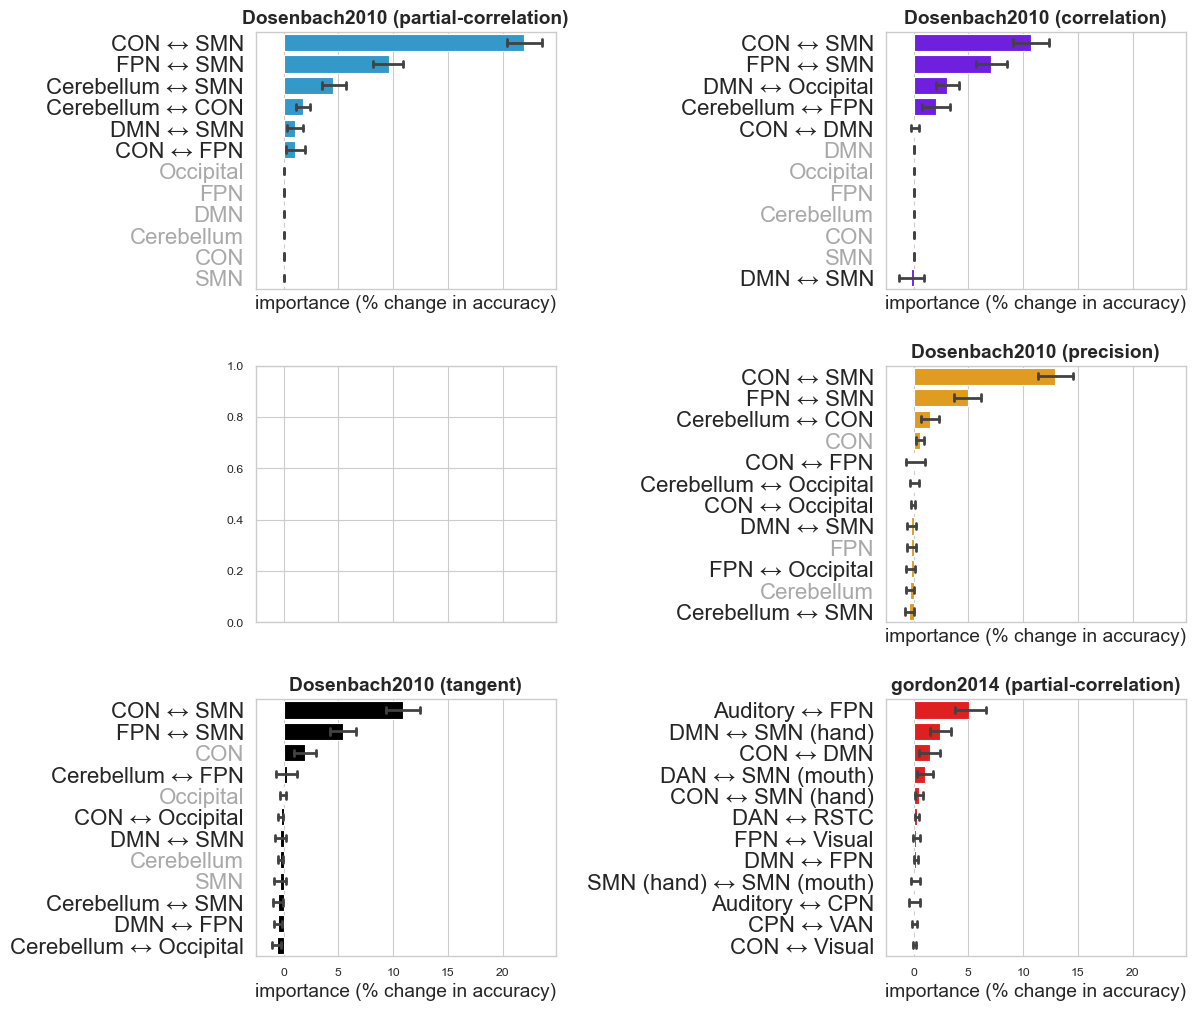

In [26]:

def clean_model_label(label):
    new_label = (label.replace('dosenbach2010', 'Dosenbach2010')
                      .replace('gordon2014_2mm', 'Gordon2014')
    )
    print(new_label)
    atlas, metric = new_label.split('_networks_', 1)
    new_label = f'{atlas} ({metric})'
    return new_label

def plot_feature_importance(results, model_name, n_features=-1, ax=None):

    top_model_names = results['grid_model_name'].values.tolist()
    color = MODEL_COLORS[top_model_names.index(model_name)]

    if f'{model_name} importances' not in results.keys():
        return
    perm_imp_scores = results[f'{model_name} importances'].to_pandas() * 100.0
    perm_imp_scores.columns = perm_imp_scores.columns.to_series().apply(clean_network_labels)
    perm_imp_order = perm_imp_scores.mean().sort_values(ascending=False).index.to_list()
    perm_imp_order = perm_imp_order[:n_features]

    g = sns.barplot(data=perm_imp_scores,
                order=perm_imp_order,
                orient='horizontal',
                capsize=.3,
                errwidth=2,
                color=color,
                ax=ax)

    g.set_yticklabels(g.get_yticklabels(), fontsize=16)
    g.set_ylabel('')
    g.set_xlabel('importance (% change in accuracy)', fontsize='x-large')
    ax.set_title(clean_model_label(model_name), fontsize='x-large', fontweight='bold')

    for tick in g.get_yticklabels():
        if '\N{left right arrow}' not in str(tick):
            tick.set_color('darkgray')

top_model_names = [f'{name}' for name in RESULTS['grid_model_name'].values[:6]]

_, axes = plt.subplots(3,2,
                       gridspec_kw={'wspace': 1.1, 'hspace': .3},
                       figsize=(12,12), sharey=False, sharex=True, squeeze=True)

for i, (model_name, ax) in enumerate(zip(top_model_names, axes.flatten())):
    plot_feature_importance(RESULTS, model_name, ax=ax, n_features=12)
    

# plt.suptitle('Permutation importance (impact on model accuracy)', fontsize='xx-large')

plt.savefig('outputs/figures/feature_importance_top6.png', dpi=300, bbox_inches='tight')
plt.show()

In [1]:
raise Exception('skipping...')
def combine_feature_importances(results, n_features=-1, ax=None):

    model_names = results['model_name'].values.tolist()

    from IPython.display import display


    imp_scores_all = []

    for model_name in model_names:
        imp_scores = results[f'{model_name} importances'].to_pandas()
        imp_scores.columns.name = None

        # debug
        # imp_scores = imp_scores.head()

        atlas, kind = model_name.split(' ', 1)
        imp_scores['atlas'] = atlas
        imp_scores['kind'] = kind

        
        imp_scores = imp_scores.reset_index().melt(
            var_name='connectivity',
            id_vars=['permutation_importance_num', 'atlas', 'kind'])


        imp_scores_all.append(imp_scores)

    imp_scores_all = pd.concat(imp_scores_all)

    return imp_scores_all

    # for tick in g.get_yticklabels():
    #     if '\N{left right arrow}' not in str(tick):
    #         tick.set_color('darkgray')

combined_feature_importances = combine_feature_importances(RESULTS)
combined_feature_importances = combined_feature_importances.query('atlas != "seitzman2018"')

g = sns.FacetGrid(combined_feature_importances, col='kind', row='atlas',
                  height=2, aspect=2,
                  dropna=True,
                  xlim=(0, 0.2),
                  sharex=False, sharey=False, margin_titles=True)


def plot_model(**kwargs):
    data = kwargs.pop('data')
    n_features = kwargs.pop('n_features', 10)

    data = data.pivot(columns='connectivity', index='permutation_importance_num', values='value')
    order = data.mean().sort_values(ascending=False).index.to_list()
    order = order[:n_features]

    sns.barplot(data=data, order=order, orient='horizontal', **kwargs)

g.map_dataframe(plot_model, n_features=10)

for (i,j,k), data in g.facet_data():
    if j == 1:
        pass
        # g.facet_axis(i, j).set(yticklabels=[])
        # g.facet_axis(i, j).set_yticks([])
    if not data.empty:
        print(data['atlas'].unique()[0])
    else:
        ax = g.facet_axis(i, j)
        ax.set_axis_off()
        # ax.set_visible(False)

plt.tight_layout()

Exception: skipping...